# Prepare DEMs for Mount Saint Helens exercise

The DEMs have different resolutions, units, and areas. We need to have both in the same units and corresponding to the same pixel locations so that can take the difference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import verde as vd

Load the data. Need to reverse the grid because the first row is the North border and Verde expects it to be South.

In [2]:
before = np.loadtxt("st-helens_before.txt")[::-1]
after = np.loadtxt("st-helens_after.txt")[::-1]

Get some properties of the data (see the headers of the files).

In [3]:
region_before = [557815.0, 567605.0, 5107985.0, 5121985.0]
region_after = [557805.0, 567615.0, 5107965.0, 5122005.0]
no_data = -32767
before[before == no_data] = np.nan
after[after == no_data] = np.nan
after /= 3.28084 # convert to metres
shape_before = before.shape
shape_after = after.shape

Generate the coordinate grids for each dataset based on the region and data shape (number of points).

In [4]:
coords_before = vd.grid_coordinates(region_before, shape=shape_before)
coords_after = vd.grid_coordinates(region_after, shape=shape_after)

Remove the not-a-number (nan) values before interpolation.

In [5]:
def strip_nans(coordinates, data):
    "Remove NaNs from the arrays"
    not_nan = np.logical_not(np.isnan(data))
    data_clean = data[not_nan].ravel()
    coords_clean = [coord[not_nan].ravel() for coord in coordinates]
    return coords_clean, data_clean

In [6]:
coords_before, before = strip_nans(coords_before, before)
coords_after, after = strip_nans(coords_after, after)

Use Verde to interpolate the data onto grids with the same region (area) and grid spacing. This way we can directly compare the two DEMs.

In [7]:
spacing = 10 # meters

In [8]:
gridder = vd.ScipyGridder(method="nearest")
before_grid = gridder.fit(coords_before, before).grid(region=region_after, spacing=spacing, adjust="region")
after_grid = gridder.fit(coords_after, after).grid(region=region_after, spacing=spacing, adjust="region")

Plot the grids.

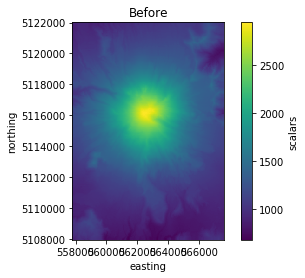

In [9]:
plt.figure()
ax = plt.subplot(111)
before_grid.scalars.plot(ax=ax)
ax.set_title("Before")
ax.set_aspect('equal')

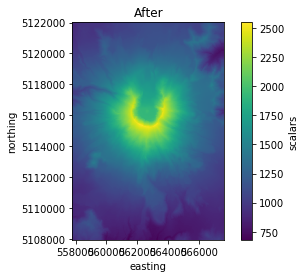

In [10]:
plt.figure()
ax = plt.subplot(111)
after_grid.scalars.plot(ax=ax)
ax.set_title("After")
ax.set_aspect('equal')

Save the grids to text files and add information on the header of each file about the resolution.

In [11]:
for name, grid in zip(["before", "after"], [before_grid, after_grid]):
    with open(f"mount-saint-helens-dem-{name}.txt", "w") as output:
        output.write(f"# DEM of Mount Saint Helens {name} the 1980 eruption\n")
        output.write(f"# unit: meters\n# resolution: {spacing} meters\n")
        np.savetxt(output, grid.scalars.values[::-1], fmt="%d")